# Import libraries

In [258]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [259]:
df=pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army flyer flown by Orville Wright nose-dived into the ground from a height of approximately 75 feet, killing Lt. Thomas E. Selfridge who was a passenger. This was the first recorded airplane fatality in history. One of two propellers separated in flight, tearing loose the wires bracing the rudder and causing the loss of control of the aircraft. Orville Wright suffered broken ribs, pelvis and a leg. Selfridge suffered a crushed skull and died a short time later."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,"First U.S. dirigible Akron exploded just offshore at an altitude of 1,000 ft. during a test flight."
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,"The first fatal airplane accident in Canada occurred when American barnstormer, John M. Bryant, California aviator was killed."
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encountered a severe downdraft crashing 20 miles north of Helgoland Island into the sea. The ship broke in two and the control car immediately sank drowning its occupants.
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,"Hydrogen gas which was being vented was sucked into the forward engine and ignited causing the airship to explode and burn at 3,000 ft.."


In [260]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Year'].head(5)

0    1908
1    1912
2    1913
3    1913
4    1913
Name: Year, dtype: int64

# Data Cleaning

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3562 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
 13  Year          5268 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 576.3+ KB


In [262]:
df.columns

Index(['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'Type',
       'Registration', 'cn/In', 'Aboard', 'Fatalities', 'Ground', 'Summary',
       'Year'],
      dtype='object')

In [263]:
df.isna().sum()

Date            0   
Time            2219
Location        20  
Operator        18  
Flight #        4199
Route           1706
Type            27  
Registration    335 
cn/In           1228
Aboard          22  
Fatalities      12  
Ground          22  
Summary         390 
Year            0   
dtype: int64

In [264]:
data = df.dropna()
data.head(3)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year
208,01/19/1930,18:23,"Oceanside, California",Maddux Airlines,7,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,NC9689,5-AT-046,16.0,16.0,0.0,"While en route to Los Angeles, the pilot, flying a low altitude due to poor weather conditions tried to turn back. While in a left turn his left wing struck a hill, crashed and burned. Adverse weather conditions. The plane flew into a sudden squall which cause the pilot to lose control.",1930
236,03/31/1931,10:45,"Bazaar, Kansas",Trans Continental and Western Air,599,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,NC-999,1063,8.0,8.0,0.0,"Shortly after taking off from Kansas City, one of the aircraft's wing's separated in flight after penetrating a thunderstorm and experiencing strong turbulence and icing. The plane crashed into a wheat field. Wing-aileron flutter, brought about by moisture leaking into the wing's interior, weakening the glue that bonded the wooden spars. Notre Dame football coach, Knute Rockne, 43, killed.",1931
334,08/31/1934,23:42,"Amazonia, Missouri",Rapid Air Transport,6,Omaha - St. Joseph,Stinson SM-6000B,NC10809,5004,5.0,5.0,0.0,The plane crashed about 11 miles from St. Joseph in heavy fog. Pilot error in taking off in dangerous weather conditions and turning too close the the ground in a fog-bound area. Inaccurate weather conditions reported to the pilot.,1934


In [265]:
print('number of rows  before discarding duplicates = %d' % (data.shape[0]))
airplane= data.drop_duplicates()
print("number of rows after discarding duplicates = %d" % (data.shape[0]))

number of rows  before discarding duplicates = 944
number of rows after discarding duplicates = 944


In [266]:
airplane.isnull().values.any()

False

# EDA

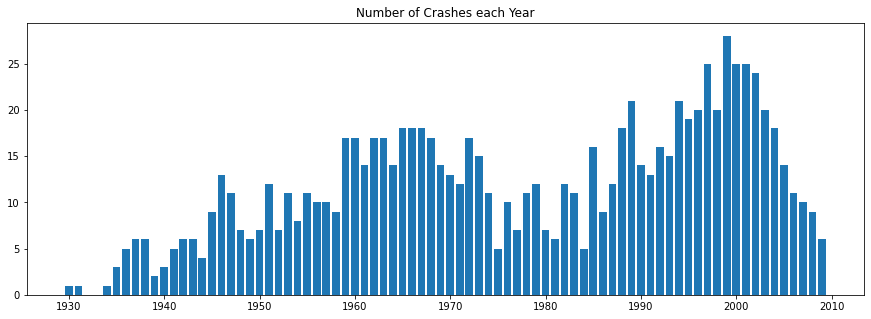

In [267]:
Crshs=pd.DataFrame(airplane.Year.value_counts())

plt.figure(figsize=(15, 5))
plt.bar(x=Crshs.index, height=Crshs["Year"])
plt.title("Number of Crashes each Year")
plt.show()

<AxesSubplot:title={'center':'Top 15 countries by crash locations'}>

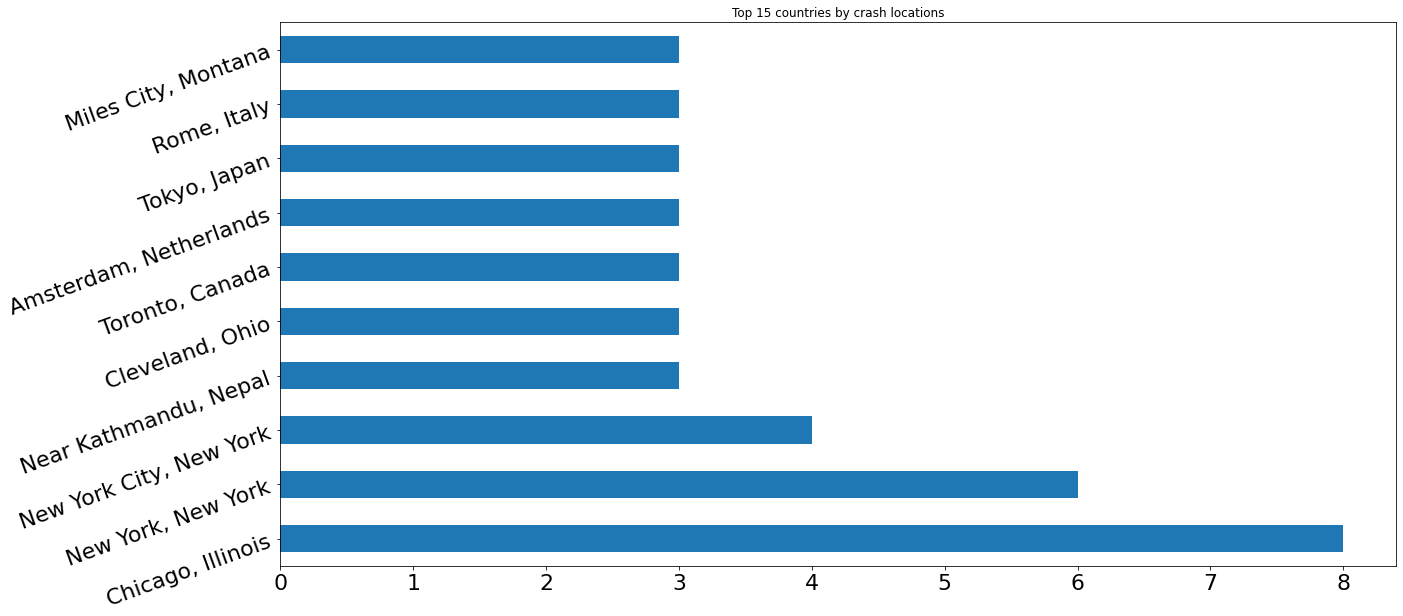

In [268]:
airplane['Location'].value_counts()[:10].plot(kind='barh'
                                        ,  figsize=(20,10), rot=20, fontsize=22, title="Top 15 countries by crash locations")

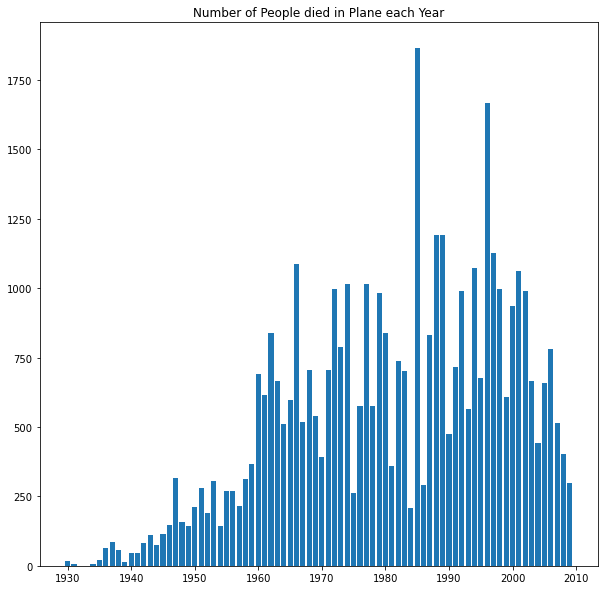

In [269]:
fatals=pd.DataFrame(airplane.Fatalities.groupby(airplane.Year).sum())

plt.figure(figsize=(10, 10))
plt.bar(x=fatals.index, height=fatals["Fatalities"])
plt.title("Number of People died in Plane each Year")
plt.show()

In [270]:
airplane['Survivor']=airplane['Aboard']-airplane['Fatalities']
airplane.head(2)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year,Survivor
208,01/19/1930,18:23,"Oceanside, California",Maddux Airlines,7,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,NC9689,5-AT-046,16.0,16.0,0.0,"While en route to Los Angeles, the pilot, flying a low altitude due to poor weather conditions tried to turn back. While in a left turn his left wing struck a hill, crashed and burned. Adverse weather conditions. The plane flew into a sudden squall which cause the pilot to lose control.",1930,0.0
236,03/31/1931,10:45,"Bazaar, Kansas",Trans Continental and Western Air,599,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,NC-999,1063,8.0,8.0,0.0,"Shortly after taking off from Kansas City, one of the aircraft's wing's separated in flight after penetrating a thunderstorm and experiencing strong turbulence and icing. The plane crashed into a wheat field. Wing-aileron flutter, brought about by moisture leaking into the wing's interior, weakening the glue that bonded the wooden spars. Notre Dame football coach, Knute Rockne, 43, killed.",1931,0.0


In [271]:
FSG_per_year = airplane[['Year', 'Fatalities', 'Survivor', 'Ground']].groupby('Year').sum()
FSG_per_year = FSG_per_year.reset_index()

Text(0, 0.5, 'Count')

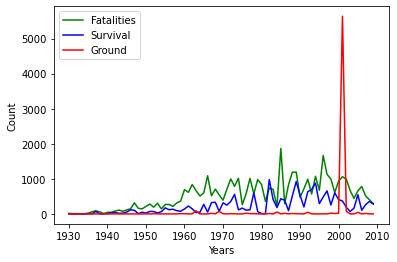

In [272]:
sns.lineplot(x = 'Year', y = 'Fatalities', data = FSG_per_year, color = 'green')
sns.lineplot(x = 'Year', y = 'Survivor', data = FSG_per_year, color = 'blue')
sns.lineplot(x = 'Year', y = 'Ground', data = FSG_per_year, color = 'red')
plt.legend(['Fatalities', 'Survival', 'Ground'])
plt.xlabel('Years')
plt.ylabel('Count')

In [273]:
Locations = airplane.groupby('Location', as_index=False).agg({'Year':'mean'}).sort_values('Year', ascending=False)

In [274]:
fig = px.choropleth(Locations, 
                    locations = 'Location', 
                    locationmode = 'country names', 
                    color = 'Year',
                    hover_data = ['Year'], 
                    title = 'Most Dangerous Locations per years')
fig.show()

In [275]:
SurvivorByPlaneType=pd.DataFrame(airplane.Survivor.groupby(airplane.Type).sum())
SurvivorByPlaneType = SurvivorByPlaneType.sort_values(by='Survivor', ascending=False)
SurvivorByPlaneType.head(5)

,Survivor
Type,
McDonnell Douglas DC-10-30,871.0
McDonnell Douglas DC-10-30CF,838.0
Boeing B-747-122,739.0
Boeing B-747-121,586.0
McDonnell Douglas DC-10-10,527.0


<AxesSubplot:title={'center':'Top 5 Airplane Type has number of Survivor'}, ylabel='Type'>

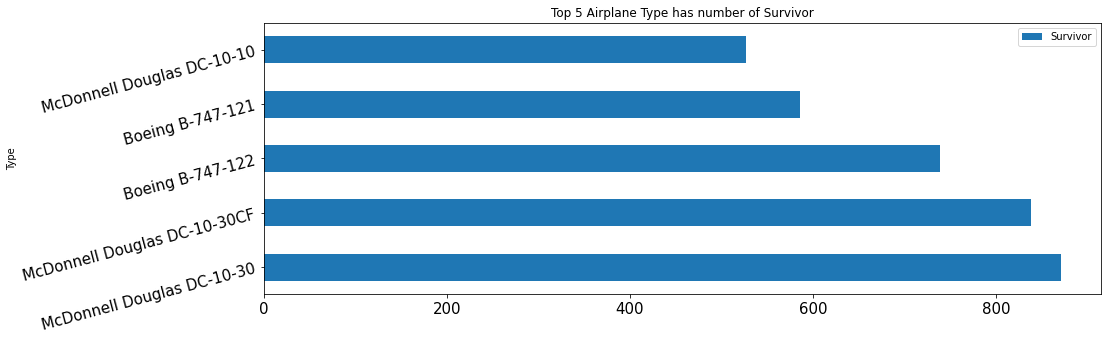

In [276]:
SurvivorByPlaneType[:5].plot(kind='barh'
                                        ,  figsize=(15,5), rot=15, fontsize=15, title="Top 5 Airplane Type has number of Survivor")

In [277]:
CrashesByPlaneType=pd.DataFrame(airplane.Fatalities.groupby(airplane.Type).sum())
CrashesByPlaneType = CrashesByPlaneType.sort_values(by='Fatalities', ascending=False)
CrashesByPlaneType.head(5)

,Fatalities
Type,
Douglas DC-3,929.0
McDonnell Douglas DC-10-10,804.0
McDonnell Douglas DC-9-32,650.0
Tupolev TU-154M,640.0
Boeing B-747-121 / Boeing B-747-206B,583.0


<AxesSubplot:title={'center':'Top 5 Airplane Type has number of Fatalities'}, ylabel='Type'>

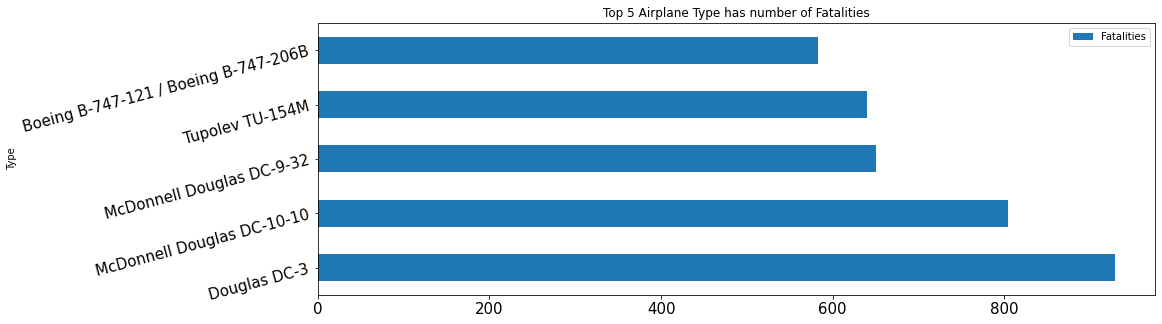

In [278]:
CrashesByPlaneType[:5].plot(kind='barh'
                                        ,  figsize=(15,5), rot=15, fontsize=15, title="Top 5 Airplane Type has number of Fatalities")

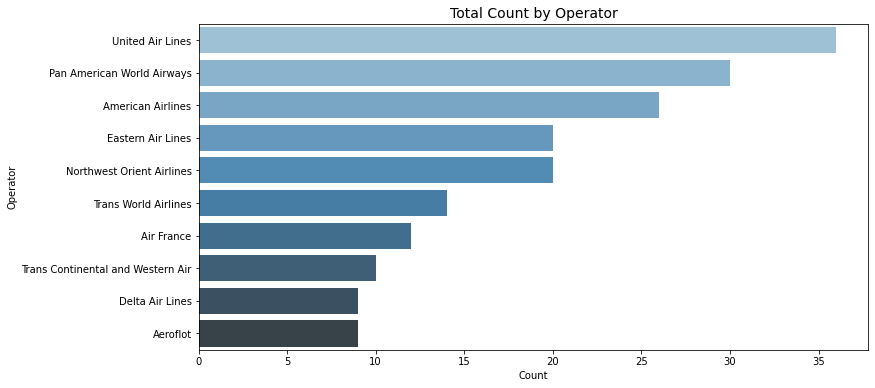

In [279]:
Opreator_total = airplane.groupby('Operator')[['Operator']].count()
Opreator_total = Opreator_total.rename(columns={"Operator": "Count"}) 
Opreator_total = Opreator_total.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=Opreator_total.index, x="Count", data=Opreator_total,palette="Blues_d",orient='h')
plt.xlabel('Count', fontsize=10)
plt.ylabel('Operator', fontsize=10)
plt.title('Total Count by Operator', loc='Center', fontsize=14)
plt.show()

# Data Pre-processing

In [280]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text
airplane['Summary_clean'] = airplane['Summary'].apply(clean_text)
airplane.head()

# StopWords

from nltk.corpus import stopwords
data_text = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
data_text = data_text + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in data_text)
    return text
    
airplane['Summary_clean'] = airplane['Summary_clean'].apply(remove_stopwords)
airplane.head(2)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year,Survivor,Summary_clean
208,01/19/1930,18:23,"Oceanside, California",Maddux Airlines,7,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,NC9689,5-AT-046,16.0,16.0,0.0,"While en route to Los Angeles, the pilot, flying a low altitude due to poor weather conditions tried to turn back. While in a left turn his left wing struck a hill, crashed and burned. Adverse weather conditions. The plane flew into a sudden squall which cause the pilot to lose control.",1930,0.0,en route los angeles pilot flying low altitude due poor weather conditions tried turn back left turn left wing struck hill crashed burned adverse weather conditions plane flew sudden squall cause pilot lose control
236,03/31/1931,10:45,"Bazaar, Kansas",Trans Continental and Western Air,599,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,NC-999,1063,8.0,8.0,0.0,"Shortly after taking off from Kansas City, one of the aircraft's wing's separated in flight after penetrating a thunderstorm and experiencing strong turbulence and icing. The plane crashed into a wheat field. Wing-aileron flutter, brought about by moisture leaking into the wing's interior, weakening the glue that bonded the wooden spars. Notre Dame football coach, Knute Rockne, 43, killed.",1931,0.0,shortly taking kansas city one aircrafts wings separated flight penetrating thunderstorm experiencing strong turbulence icing plane crashed wheat field wingaileron flutter brought moisture leaking wings interior weakening glue bonded wooden spars notre dame football coach knute rockne killed


In [281]:
#Stemmer

import nltk

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
airplane['Summary_clean'] = airplane['Summary_clean'].apply(stemm_text)
airplane.head(2)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year,Survivor,Summary_clean
208,01/19/1930,18:23,"Oceanside, California",Maddux Airlines,7,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,NC9689,5-AT-046,16.0,16.0,0.0,"While en route to Los Angeles, the pilot, flying a low altitude due to poor weather conditions tried to turn back. While in a left turn his left wing struck a hill, crashed and burned. Adverse weather conditions. The plane flew into a sudden squall which cause the pilot to lose control.",1930,0.0,en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control
236,03/31/1931,10:45,"Bazaar, Kansas",Trans Continental and Western Air,599,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,NC-999,1063,8.0,8.0,0.0,"Shortly after taking off from Kansas City, one of the aircraft's wing's separated in flight after penetrating a thunderstorm and experiencing strong turbulence and icing. The plane crashed into a wheat field. Wing-aileron flutter, brought about by moisture leaking into the wing's interior, weakening the glue that bonded the wooden spars. Notre Dame football coach, Knute Rockne, 43, killed.",1931,0.0,short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn kill


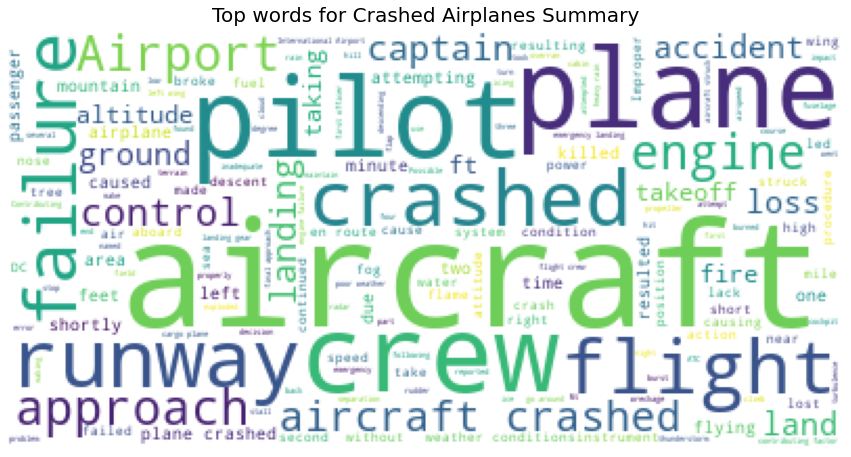

In [282]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in airplane['Summary']))
plt.figure(figsize=(15,10))
plt.title('Top words for Crashed Airplanes Summary', 
          fontdict={'size': 20,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [283]:
airplane['Summary_clean'].nunique() 

944

# Kmeans Cluster

In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [285]:
documents = list(airplane['Summary_clean'])
vectorizer = TfidfVectorizer(stop_words='english') # Stop words are like "a", "the", or "in" which don't have significant meaning
X = vectorizer.fit_transform(documents)

In [286]:
model = MiniBatchKMeans(n_clusters=5, random_state=100)
model.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=100)

In [287]:
model.cluster_centers_

array([[0.        , 0.        , 0.00042574, ..., 0.        , 0.        ,
        0.        ],
       [0.00086522, 0.00038335, 0.00326747, ..., 0.        , 0.        ,
        0.00185974],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00371058, 0.        ,
        0.        ],
       [0.        , 0.        , 0.00138527, ..., 0.        , 0.00418625,
        0.        ]])

In [288]:
print ('Most Common Terms per Cluster:')

order_centroids = model.cluster_centers_.argsort()[:,::-1] #sort cluster centers by proximity to centroid
terms = vectorizer.get_feature_names()

for i in range(5):
    print("\n")
    print('Cluster %d:' % i)
    for j in order_centroids[i, :10]: #replace 10 with n words per cluster
        print ('%s' % terms[j]),
    print

Most Common Terms per Cluster:


Cluster 0:
aircraft
plane
crash
hijack
pilot
kill
fuel
collis
caus
passeng


Cluster 1:
approach
runway
aircraft
land
crash
crew
pilot
plane
attempt
airport


Cluster 2:
deton
explos
crash
devic
bomb
plane
aboard
minut
explod
cabin


Cluster 3:
mountain
flight
ft
aircraft
terrain
pilot
crash
navig
error
condit


Cluster 4:
engin
failur
aircraft
takeoff
crash
plane
power
loss
left
lost


In [289]:
pca = PCA(n_components=13, random_state=100)
reduced_features = pca.fit_transform(X.toarray())

reduced_cluster_centers = pca.transform(model.cluster_centers_)

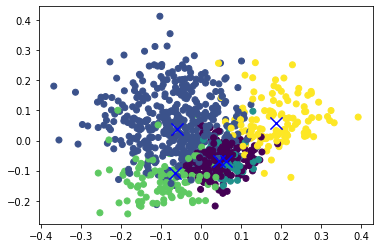

In [290]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# Modeling

In [291]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

# NMF

In [292]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [293]:
df=airplane[['Summary_clean','Operator','Location']]

In [294]:
pd.set_option('display.max_colwidth',-1)
df.head(2)

<ipython-input-294-80fd2a1a75bd>:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,Summary_clean,Operator,Location
208,en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control,Maddux Airlines,"Oceanside, California"
236,short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn kill,Trans Continental and Western Air,"Bazaar, Kansas"


In [295]:
X_train, X_test = train_test_split(df, test_size=0.3, random_state=100)

In [296]:
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [297]:
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
    tokens = map(str.lower, tokens)
    stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
    return stems

In [298]:
# Instatiate
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
# Fit & Transform
tfidf_vectors = vectorizer.fit_transform(X_train['Summary_clean'].values.astype('U')) ## Even astype(str) would work

In [299]:
clf = decomposition.NMF(n_components=5, random_state=111) 

W1 = clf.fit_transform(tfidf_vectors)
H1 = clf.components_

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [300]:
num_words=15 # 

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [301]:
topics

['approach descent crew altitud aircraft visual instrument short runway descend short final crash minimum captain aircraft crash',
 'engin failur takeoff engin failur left power fire ditch left engin right engin emerg loss aircraft fail flight',
 'runway land attempt attempt land plane overran overran runway airport gear pilot land gear flame touch burst burst flame',
 'aircraft control crash plane caus minut take fire loss aircraft crash plane crash aboard kill passeng thunderstorm',
 'mountain condit weather pilot weather condit flight terrain poor poor weather plane error crash area mile mountain terrain']

In [302]:
colnames = ["pilot error","On Fire","shot down","poor weather"
                               ,"crash"]
docnames = ["Doc" + str(i) for i in range(len(X_train.Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic

,pilot error,On Fire,shot down,poor weather,crash,dominant_topic
Doc0,0.04,0.01,0.00,0.02,0.11,4
Doc1,0.04,0.01,0.08,0.10,0.01,3
Doc2,0.00,0.01,0.01,0.18,0.00,3
Doc3,0.00,0.15,0.00,0.00,0.00,1
Doc4,0.16,0.00,0.04,0.02,0.01,0
...,...,...,...,...,...,...
Doc655,0.00,0.00,0.05,0.09,0.11,4
Doc656,0.02,0.02,0.22,0.00,0.03,2
Doc657,0.00,0.00,0.01,0.03,0.10,4
Doc658,0.06,0.00,0.03,0.08,0.04,3


In [303]:
X_train.head()

,Summary_clean,Operator,Location
1121,plane crash north slope santa ynez peak mile northwest santa barbara poor weather failur crew maintain minimum altitud rout flown reason unknown,Southwest Airways,"Refugio Pass, near Santa Barbara, California"
3529,aircraft crash return airport report sever vibrat attempt land aircraft crash field bounc slid mobil home ground handler forgot close air start access door crew failur control monitor flight path air speed aircraft detect vibrat,Galaxy Airlines,"Reno, Nevada"
4773,aircraft explod caught fire minut schedul takeoff five member cabin crew peopl aboard plane time wit said heard explos flame erupt aboard aircraft ntsb investig report center fuel tank explod follow right tank minut later caus explos unclear center fuel tank locat near air condit pack generat heat run nonstop prior explos,Thai Airways,"Bangkok, Thailand"
833,crash loos power engin due fuel starvat accumul carburetor ice follow loss power engin result fuel starvat reason fuel starvat could determin,American Airlines,"Michigan City, Indiana"
938,execut second instrument approach shannon airport aircraft struck ground feet approach end intend runway broke apart burn continu instrument approach altitud insuffici clear terrain failur fluoresc light may contribut caus plane name clipper empress sky,Pan American World Airways,"Shannon, Ireland"


In [304]:
Wtest = clf.transform(vectorizer.transform(X_test.Summary_clean[:10]))

In [305]:
colnames = ["pilot error","On Fire","crash","poor weather","shot down"]
docnames = ["Doc" + str(i) for i in range(len(X_test[:10].Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(Wtest, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head(10)

,pilot error,On Fire,crash,poor weather,shot down,dominant_topic
Doc0,0.126,0.000,0.145,0.004,0.045,2
Doc1,0.041,0.025,0.075,0.094,0.000,3
Doc2,0.153,0.000,0.000,0.000,0.023,0
Doc3,0.007,0.000,0.004,0.155,0.000,3
Doc4,0.000,0.042,0.199,0.000,0.000,2
Doc5,0.091,0.248,0.031,0.000,0.003,1
Doc6,0.045,0.113,0.000,0.033,0.064,1
Doc7,0.052,0.000,0.048,0.000,0.054,4
Doc8,0.037,0.012,0.178,0.072,0.000,2
Doc9,0.001,0.006,0.000,0.204,0.000,3


# LDA

In [306]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))

tf_vectors = vectorizer.fit_transform(X_train['Summary_clean'].values.astype('U'))

In [307]:
lda = decomposition.LatentDirichletAllocation(n_components=3, max_iter=3, learning_method='online', learning_offset=50, n_jobs=-1, random_state=100)

W1 = lda.fit_transform(tf_vectors)
H1 = lda.components_

In [308]:
num_words=10

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [309]:
topics

['shot rout deton explo compart devic crew forc aircraft deton crash',
 'mountain approach crash aircraft prematur navig flight mile prematur descent error',
 'aircraft crash plane land engin pilot approach crew runway failur']

In [310]:
colnames = ["pilot error","On Fire","crash"]
docnames = ["Doc" + str(i) for i in range(len(X_train.Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head(10)

,pilot error,On Fire,crash,dominant_topic
Doc0,0.07,0.07,0.87,2
Doc1,0.06,0.06,0.88,2
Doc2,0.06,0.06,0.89,2
Doc3,0.08,0.09,0.83,2
Doc4,0.06,0.06,0.89,2
Doc5,0.08,0.08,0.84,2
Doc6,0.06,0.06,0.88,2
Doc7,0.06,0.06,0.89,2
Doc8,0.05,0.05,0.90,2
Doc9,0.06,0.06,0.87,2


In [311]:
X_train.head()

,Summary_clean,Operator,Location
1121,plane crash north slope santa ynez peak mile northwest santa barbara poor weather failur crew maintain minimum altitud rout flown reason unknown,Southwest Airways,"Refugio Pass, near Santa Barbara, California"
3529,aircraft crash return airport report sever vibrat attempt land aircraft crash field bounc slid mobil home ground handler forgot close air start access door crew failur control monitor flight path air speed aircraft detect vibrat,Galaxy Airlines,"Reno, Nevada"
4773,aircraft explod caught fire minut schedul takeoff five member cabin crew peopl aboard plane time wit said heard explos flame erupt aboard aircraft ntsb investig report center fuel tank explod follow right tank minut later caus explos unclear center fuel tank locat near air condit pack generat heat run nonstop prior explos,Thai Airways,"Bangkok, Thailand"
833,crash loos power engin due fuel starvat accumul carburetor ice follow loss power engin result fuel starvat reason fuel starvat could determin,American Airlines,"Michigan City, Indiana"
938,execut second instrument approach shannon airport aircraft struck ground feet approach end intend runway broke apart burn continu instrument approach altitud insuffici clear terrain failur fluoresc light may contribut caus plane name clipper empress sky,Pan American World Airways,"Shannon, Ireland"


In [312]:
Wtest = lda.transform(vectorizer.transform(X_test.Summary_clean[:5]))

In [313]:
colnames = ["pilot error","On Fire","crash"]
docnames = ["Doc" + str(i) for i in range(len(X_test.Summary_clean[:5]))]
df_doc_topic = pd.DataFrame(np.round(Wtest, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head(10)

,pilot error,On Fire,crash,dominant_topic
Doc0,0.07,0.07,0.87,2
Doc1,0.06,0.06,0.88,2
Doc2,0.09,0.09,0.82,2
Doc3,0.09,0.09,0.83,2
Doc4,0.06,0.06,0.88,2
